In [1]:
#! /usr/bin/env python3
# https://github.com/huggingface/transformers/blob/main/examples/research_projects/rag-end2end-retriever/finetune_rag.py

from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
import pandas as pd
import random
import torch
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

In [2]:
df_train = pd.read_csv("../../../data_pre_processed/fold-1/articles_train.csv")
corpus_train = pd.read_csv("../../../data_pre_processed/fold-1/corpus_train.csv")

In [3]:
df_val = pd.read_csv("../../../data_pre_processed/fold-2/articles_train.csv")
corpus_val = pd.read_csv("../../../data_pre_processed/fold-2/corpus_train.csv")

In [4]:
train_contexts = corpus_train["text"].tolist()
train_questions = df_train["query"].tolist()
train_answers = df_train["text_w/o_heading_first_sentence_by_section"].tolist()

val_contexts = corpus_val["text"].tolist()
val_questions = df_val["query"].tolist()
val_answers = df_val["text_w/o_heading_first_sentence_by_section"].tolist()

In [5]:
ctx_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
qst_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.weight', 'ctx_encoder.bert_model.pooler.dense.bias']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['question_encoder.bert_model.encoder.layer.10.intermediate.dense.weight', 'question_encoder.bert_model.encoder.layer.0.attention.output.dense.bias', 'question_encoder.bert_

In [6]:
query_model_name = "facebook/dpr-question_encoder-single-nq-base"
passage_model_name = "facebook/dpr-ctx_encoder-single-nq-base"

query_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained(query_model_name)
passage_tokenizer = DPRContextEncoderTokenizer.from_pretrained(passage_model_name)
query_model = DPRQuestionEncoder.from_pretrained(query_model_name)
passage_model = DPRContextEncoder.from_pretrained(passage_model_name)

query_model.train()
passage_model.train()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.
Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequence

DPRContextEncoder(
  (ctx_encoder): DPREncoder(
    (bert_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)


In [7]:
train_query_encodings = query_tokenizer(train_questions, truncation=True, padding=True, return_tensors = 'pt')
train_context_encodings = passage_tokenizer(train_contexts, truncation=True, padding=True, return_tensors = 'pt')

val_query_encodings = query_tokenizer(val_questions, truncation=True, padding=True, return_tensors = 'pt')
val_context_encodings = passage_tokenizer(val_contexts, truncation=True, padding=True, return_tensors = 'pt')

In [8]:
class DPR(nn.Module):
  def __init__(self, query_model, passage_model, query_tokenizer, passage_tokenizer,
              dense_size, freeze_params = 0.0, batch_size = 2, sample_size = 4):

    '''
    :query_model : The model that encodes queries to dense representation
    :passage_model : The model that encodes passages to dense representation
    :query_tokenizer : tokenizer for queries
    :passage_tokenizer : tokenizer for passages
    :passage_dict : dictionary of passages with their unique id
    :questions : A list of tuples with question and their correct passage id
    :dense_size : the dimension to which the DPR has to encode
    :freeze_params : the percentage of the parameters to be frozen
    :batch_size : the batch size for training
    :sample_size: the sample size for negative sampling
    '''
    super(DPR, self).__init__()
    self.query_model = query_model
    self.query_tokenizer = query_tokenizer
    self.passage_model = passage_model
    self.passage_tokenizer = passage_tokenizer
    self.freeze_params = freeze_params
    self.sample_size = sample_size
    self.batch_size = batch_size

    self.passage_to_dense = nn.Sequential(nn.Linear(768, dense_size * 2),
                                          nn.ReLU(),
                                          nn.Linear(dense_size * 2, dense_size),
                                          nn.GELU())

    self.query_to_dense = nn.Sequential(nn.Linear(768, dense_size * 2),
                                          nn.ReLU(),
                                          nn.Linear(dense_size * 2, dense_size),
                                          nn.GELU())
    self.log_softmax = nn.LogSoftmax(dim = 1)
    self.freeze_layers()


  # Freeze the first self.freeze_params % layers
  def freeze_layers(self):
    num_query_layers = sum(1 for _ in self.query_model.parameters())
    num_passage_layers = sum(1 for _ in self.passage_model.parameters())

    for parameters in list(self.query_model.parameters())[:int(self.freeze_params * num_query_layers)]:
      parameters.requires_grad = False

    for parameters in list(self.query_model.parameters())[int(self.freeze_params * num_query_layers):]:
      parameters.requires_grad = True

    for parameters in list(self.passage_model.parameters())[:int(self.freeze_params * num_passage_layers)]:
      parameters.requires_grad = False

    for parameters in list(self.passage_model.parameters())[int(self.freeze_params * num_passage_layers):]:
      parameters.requires_grad = True

  def get_passage_vectors(self, passage):
    p_vector = self.passage_model(input_ids = passage.input_ids,
                                  attention_mask = passage.attention_mask)
    p_vector = self.query_to_dense(p_vector.pooler_output)
    return p_vector

  def get_query_vector(self, query):
    q_vector = self.query_model(input_ids = query.input_ids,
                                attention_mask = query.attention_mask)
    q_vector = self.query_to_dense(q_vector.pooler_output)
    return q_vector

  def dot_product(self, q_vector, p_vector):
    q_vector = q_vector.unsqueeze(1)
    sim = torch.matmul(q_vector, torch.transpose(p_vector, -2, -1))
    return sim

  def forward(self, context_input_ids, context_attention_mask, query_input_ids, query_attention_mask):
    dense_passage = self.passage_model(input_ids = context_input_ids, attention_mask = context_attention_mask)
    dense_query = self.query_model(input_ids = query_input_ids, attention_mask = query_attention_mask)
    dense_passage = dense_passage['pooler_output']
    dense_query = dense_query['pooler_output']
    dense_passage = self.passage_to_dense(dense_passage)
    dense_query = self.query_to_dense(dense_query)
    similarity_score = self.dot_product(dense_query, dense_passage)
    similarity_score = similarity_score.squeeze(1)
    logits = self.log_softmax(similarity_score)
    return logits, dense_query, dense_passage

In [9]:
device = torch.device("cpu") # torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
dpr_model = DPR(query_model = query_model,
                passage_model = passage_model,
                query_tokenizer = query_tokenizer,
                passage_tokenizer = passage_tokenizer,
                dense_size = 64,
                freeze_params = 0.3,
                batch_size = 2,
                sample_size = 8).to(device)

dpr_model.train()

DPR(
  (query_model): DPRQuestionEncoder(
    (question_encoder): DPREncoder(
      (bert_model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertSelfOutput(
          

In [11]:
print("model parameters :".ljust(25),sum(p.numel() for p in dpr_model.parameters()))
print("trainable parameters :".ljust(25),sum(p.numel() for p in dpr_model.parameters() if p.requires_grad == True))

model parameters :        217996672
trainable parameters :    124251520


In [12]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(dpr_model.parameters(), lr = 5e-5)

In [13]:
batch_size = 32
neg_samples = 2
num_questions = len(train_query_encodings.input_ids)
num_contexts = len(train_context_encodings.input_ids)

In [14]:
def get_batch():
  true = []
  context_input_ids_tensor = []
  context_attention_mask_tensor = []
  optimizer.zero_grad()

  true.append(1)

  ## Selecting the query and its positive context
  idx_query = random.randint(0, num_questions-1)
  idx_context = random.randint(0, num_contexts-1)
  context_input_ids = train_context_encodings.input_ids[idx_context]
  context_attention_mask = train_context_encodings.attention_mask[idx_context]
  query_input_ids = train_query_encodings.input_ids[idx_query]
  query_attention_mask = train_query_encodings.attention_mask[idx_query]
  context_input_ids_tensor.append(context_input_ids)
  context_attention_mask_tensor.append(context_attention_mask)

  ## Selecting the negative contexts which is hardcoded as 100 index from the selected positive context

  for j in range(neg_samples):
    true.append(0)
    neg_idx_1 = idx_context + 100
    neg_idx_2 = idx_context - 100
    if neg_idx_1 < num_questions:
      context_input_ids = train_context_encodings.input_ids[neg_idx_1]
      context_attention_mask = train_context_encodings.attention_mask[neg_idx_1]
      context_input_ids_tensor.append(context_input_ids)
      context_attention_mask_tensor.append(context_attention_mask)

    elif neg_idx_2 > 0:
      context_input_ids = train_context_encodings.input_ids[neg_idx_2]
      context_attention_mask = train_context_encodings.attention_mask[neg_idx_2]
      context_input_ids_tensor.append(context_input_ids)
      context_attention_mask_tensor.append(context_attention_mask)


  context_input_ids_tensor = torch.stack(context_input_ids_tensor)
  context_attention_mask_tensor = torch.stack(context_attention_mask_tensor)
  query_input_ids = query_input_ids.unsqueeze(0)
  query_attention_mask = query_attention_mask.unsqueeze(0)
  return context_input_ids_tensor, context_attention_mask_tensor, query_input_ids, query_attention_mask, true

In [22]:
batch_loss = 0
for i in range(1, 500):
  context_input_ids_tensor, context_attention_mask_tensor,query_input_ids,query_attention_mask, true = get_batch()
  pred, vec_q, vecs_p = dpr_model(context_input_ids_tensor.to(device),
                   context_attention_mask_tensor.to(device),
                   query_input_ids.to(device),
                   query_attention_mask.to(device))
  true = torch.tensor([0]).to(device)
  print("pred")
  print(pred.argsort()[0])
  print("context")
  print([passage_tokenizer.decode(p)  for p in context_input_ids_tensor])
  print('query')
  print(query_tokenizer.decode([q for q in query_input_ids[0]]))
  break
  # print(pred.size(), true.size())
  loss = criterion(pred, true)
  loss.backward()
  batch_loss += loss.item()
  optimizer.step()
  if i%20 == 0:
    print(f"Batch : {int(i/20)}  Loss : {batch_loss/20}")
    batch_loss = 0

pred
tensor([0, 2, 1])
context
['[CLS] cell signaling has been most extensively studied in the context of human diseases and signaling between cells ) of a single organism. however, cell signaling may also occur between the cells of two different organisms. in many mammals, early embryo cells exchange signals with cells of the uterus.. /.. in the human gastrointestinal tract, bacteria exchange signals with each other and with human epithelial and immune system cells. for the yeast saccharomyces cerevisiae during mating, some cells send a peptide signal ( mating factor pheromone on other yeast cells and induce them to prepare for mating. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

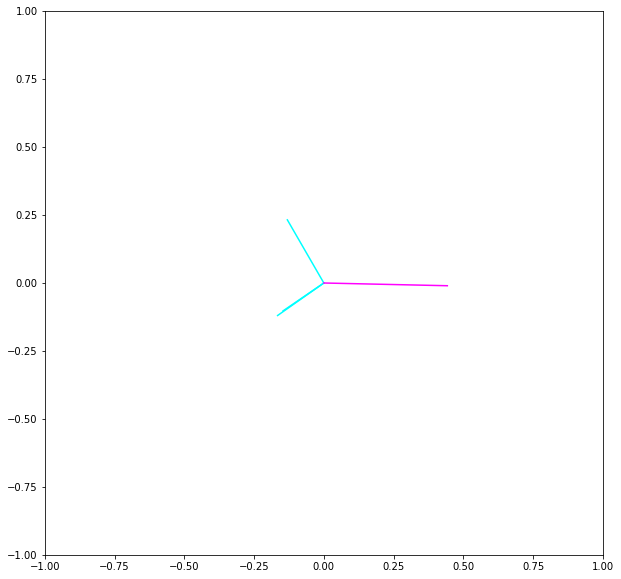

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

vectors = torch.concat((vecs_p, vec_q)).detach().numpy()
pca.fit_transform(vectors)
vec_q_transformed = pca.transform(vec_q.detach().numpy())[0]
vecs_p_transformed = pca.transform(vecs_p.detach().numpy())
plt.figure(figsize=(10,10))
plt.ylim([-1,1])
plt.xlim([-1,1])
for vec in vecs_p_transformed :
  plt.plot([0,vec[0]], [0,vec[1]], color="cyan")
plt.plot([0, vec_q_transformed[0]], [0, vec_q_transformed[1]], color="magenta")
plt.show()